# Проект "Исследование данных данные о продажах различных наименований товаров в городах Индии"

В распоряжении имеются данные из открытого источника(Kaggle.com)  о продажах различных наименований товаров в городах Индии:
* sales - информация о продажах,
* stock_transfer - информация о перемещении товарных запасов,
* sku_master - информация о начальных товарных запасах,
* opening_stock -  информация об ассортименте товаров.

**Задача:** Подготовить данные, провести разведовательный анализ данных.

**Используемые инструменты:**  
Python:
1. pandas (работа с пропусками, типами данных,  группировка, преобразование данных),
2. seaborn, matplotlib (визуалиция данных))

**Результаты:** 
1. Проведена предобработка данных.
2. Датафрейм, сформированый в Табличном редакторе(Excel)в формате сводной таблицы и имеющий двухуровневую "шапку таблицы" с объединением ячеек преобразован в формат, пригодный для проведения исследования (для исследования интереса не представил, отработан механизм преобразования).
3. Изучены количество проданных товаров и общая стоимость по городам и категориям товаров.

## Загрузка данных подготовка их к анализу

### Загрузка данных.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from re import match, findall

import warnings
warnings.simplefilter("ignore")

pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

%matplotlib inline

Загрузим данные и изучим основную информацию о них.

In [2]:
sales = pd.read_csv("Sales.csv")

stock_transfer = pd.read_csv("STOCK TRANSFER.csv")

sku_master = pd.read_csv("SKU MASTER.csv")

opening_stock = pd.read_csv("Opening Stock.csv")

### Объявление фунций, необходимых для проведения анализа

#### Функция перевода строки в змеиный регистр

In [3]:
def snake_case(string):
    return '_'.join([i.lower().replace('_', '') for i in findall(r'_*[A-Z]+[a-z]*', string)])

#### Функция определения минимальной и максимальной дат, представленных в столбце

In [4]:
def min_max_date(column):
    ''' Функция принимает столбец с даннымми в формате даты и выводит минимальное и максимальное его значение'''
    print(f'Минимальная дата, представленная в столбце: {column.min()}',
          f'Максимальная дата, представленная в столбце: {column.max()}', sep = '\n')

#### Функция отображения общей информации о датафрейме

In [5]:
def inform (data, dict_1 = None):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит основную информацию о каждом из его столбцов:
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан 
    словарь содержащий необходимую информацию);
    * тип данных;
    * информацию о наличии пропусков и выбросов.
    '''
    if dict_1 == None:
        dict_1 = {}
    print(f'Количество строк в датафрейме: {data.shape[0]}\n\nИнформация о столбцах датафрейма:\n')
    n = 1
    for column in data.columns:
        print(n,')',sep = '', end = ' ')
        try:
            print(f'Столбец "{column}" - {dict_1[column]}:')
        except:
            print(f'Столбец "{column}":')
        print(f'Тип данных: {data[column].dtype}')
        print(f'Количество уникальных значений: {data[column].nunique()}.')
        if data[column].isna().sum() == 0:
            print('Пропуски отсутствуют.')
        else: 
            print(f'Количество пропусков в столбце: {data[column].isna().sum()} ({data[column].isna().sum()/len(data):.2%}).')
        try:
            q1,q3 = data[column].quantile(0.25), data[column].quantile(0.75)
            iqr = q3 - q1
            data1 = data.loc[(data[column] < (q3 + 1.5*iqr)) & (data[column] > (q1 - 1.5*iqr))]
            length = len(data1)+data[column].isna().sum()
            if length == len(data):
                print('Выбросы отсутствуют.')
            else:
                print(f'Количество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
        except:
            pass
        print('-'*45)
        n+=1

#### Функция визуализации 

In [6]:
def visualize(col_1, col_2):
    name_1 = {'category': ['категориям', 'Категории товаров'],
            'city': ['городам', 'Города']}
    name_2 = {'sales': ['количества проданных товаров','Количество проданных товаров'],
            'total_amount': ['общей стоимости проданных товаров', 'Общая стоимость проданных товаров']}
    total_1 = (data.pivot_table(index = col_1, values = col_2, aggfunc = 'sum')
               .sort_values(col_2, ascending = False)
               .reset_index()
               .loc[:4])
    col_list = total_1[col_1].to_list()
    sum_c = (data.pivot_table(index = col_1, values = col_2, aggfunc = 'sum')
             .sort_values(col_2, ascending = False)
             .iloc[5:]
             .sum()[0])
    if sum_c > 0:
        total_1.loc[5] = ['Оther(Прочие)', sum_c]

    total_2 = (data[data[col_1].isin(col_list)]
               .groupby([col_1,'date'])[col_2].sum()
               .reset_index()
               .sort_values(col_2, ascending = False))
    
    total_1 = total_1.sort_values(col_1)# для обеспечения одинаковой цветовой гаммы на графиках
    total_2 = total_2.sort_values(col_1)
    
    plt.figure(figsize=(15, 5))
    plt.rcParams['font.size'] = 10.0
    plt.subplots_adjust(wspace= 1)
    
    plt.subplot(1, 5, (1,2)) 
    plt.pie(total_1[col_2], labels=total_1[col_1],autopct='%.0f%%')
    plt.title(f'{name_2[col_2][1]}  по  {name_1[col_1][0]}')

    plt.subplot(1, 5, (3,5))
    sns.lineplot(data = total_2, x = 'date', y = col_2, hue = col_1, palette = 'tab10')
    plt.title(f'Динамика {name_2[col_2][0]} по {name_1[col_1][0]}')
    plt.xlabel('Дата')
    plt.ylabel(name_2[col_2][1])
    plt.xticks(rotation = 60)
    plt.show()

### Изучение и предобработка данных

#### Изучение и предобработка данных в датасете "sales"(информация о продажах)

Выведем общую информацию о данных.

In [7]:
sales.head()

,Date,SKU,Product Name,City,Sales
0,2023-01-01 0:00:00,F001,Prateek England,Mumbai,93
1,2023-01-01 0:00:00,F002,Lucy Phillepe,Mumbai,36
2,2023-01-01 0:00:00,F003,Badlands,Mumbai,7
3,2023-01-01 0:00:00,F004,Allen Dolly,Mumbai,55
4,2023-01-01 0:00:00,F005,Bucchi,Mumbai,41


In [8]:
inform(sales)

Количество строк в датафрейме: 6200

Информация о столбцах датафрейма:

1) Столбец "Date":
Тип данных: object
Количество уникальных значений: 30.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "SKU":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "Product Name":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "City":
Тип данных: object
Количество уникальных значений: 4.
Пропуски отсутствуют.
---------------------------------------------
5) Столбец "Sales":
Тип данных: int64
Количество уникальных значений: 224.
Пропуски отсутствуют.
Количество выбросов в столбце: 330 (5.32%).
---------------------------------------------


Переведем наименования столбцов в змеиный регистр, а также откорректируем тип данных в столбце с датой.

In [9]:
sales.rename(columns = {i: snake_case(i) for i in sales.columns}, inplace = True)
sales['date'] = pd.to_datetime(sales['date'])

In [10]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200 entries, 0 to 6199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          6200 non-null   datetime64[ns]
 1   sku           6200 non-null   object        
 2   product_name  6200 non-null   object        
 3   city          6200 non-null   object        
 4   sales         6200 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 242.3+ KB


Определим минимальнцю и максимальную даты, информация о продажах в которые представлена в данных.

In [11]:
min_max_date(sales['date'])

Минимальная дата, представленная в столбце: 2023-01-01 00:00:00
Максимальная дата, представленная в столбце: 2023-01-30 00:00:00


Данные содержат 6200 строк о продажах различных товаров за период с 1 по 30 января 2023 года.
При этом каждая строка предположительно соответствует количеству проданных товаров одного наименования в определенную дату в конкретном городе.
Однако количество уникальных значений в столбцах с наименованием города, артикулом и датой(4, 50 и 30 соответственно), и их произведение(6000), позволяют предположить, что в данных могут присутствовать дубликаты, поэтому их следует изучить дополнительно.

Проверим данные на наличие явных дубликатов.

In [12]:
sales.duplicated().sum()

2

В данных присутствует всего 2 явных дубликата.  
Проверим на дубликаты столбцы с наименованием города, артикулом и датой продажи.

In [13]:
sales[['date','city', 'sku']].duplicated().sum()

200

Предположение подтвердилось. В данных присутcтвуют 200 неявных дубликатов. 
Изучим данные дубликаты подробнее.

In [14]:
sales[sales[['date','city', 'sku']].duplicated(keep = False)].sort_values(['city', 'sku'])

,date,sku,product_name,city,sales
6060,2023-01-29,B001,Harry putar,Aurangabad,6
6110,2023-01-29,B001,Harry putar,Aurangabad,26
6061,2023-01-29,B002,4 states,Aurangabad,30
6111,2023-01-29,B002,4 states,Aurangabad,41
6062,2023-01-29,B003,Shaktiman Returns,Aurangabad,46
...,...,...,...,...,...
4567,2023-01-29,V003,Pacman,Pune,6
4518,2023-01-29,V004,LTA Wise City,Pune,49
4568,2023-01-29,V004,LTA Wise City,Pune,50
4519,2023-01-29,V005,HIFA 2023,Pune,17


In [15]:
sales[sales[['date','city', 'sku']].duplicated(keep = False)].date.unique()

<DatetimeArray>
['2023-01-29 00:00:00']
Length: 1, dtype: datetime64[ns]

Задвоение информации о продажах произошло 29.01.2023 по всем категориям товаров и по всем городам.  Вероятнее всего это было связано с техническим сбоем, природа которого не ясна.

Возможно в данную дату произошло сохранение промежуточного и конечного итогов, и в таком случае необходимо было бы удалить дубликаты с минимальными значениями в столбце с продажами. Однако существует вероятность, что дубликаты содержат информацию о разных продажах,и необходимо суммировать значения.

Визуализируем динамику изменения общего количества проданных единиц товара во времени, просуммировав значения в строках с неявными дубликатами.

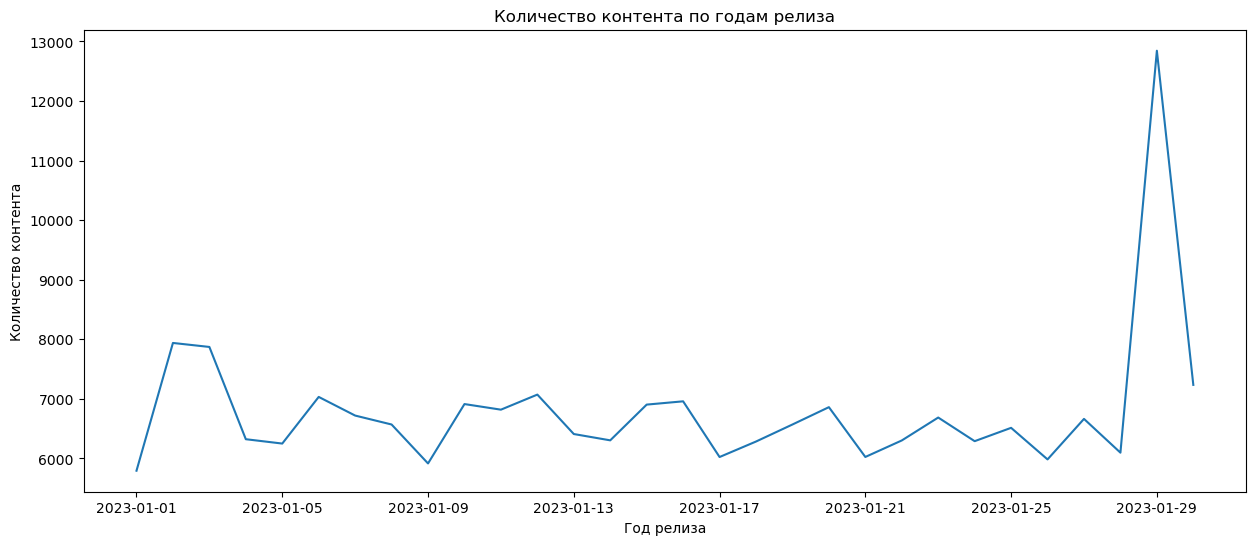

In [16]:
dub_sales = sales.groupby(['date']).sales.sum().reset_index()
plt.figure(figsize=(15,6))
sns.lineplot(data = dub_sales, x = 'date', y = 'sales', palette = 'tab10')
plt.title(f'Количество контента по годам релиза')
plt.xlabel('Год релиза')
plt.ylabel('Количество контента')
plt.show()

На графике наблюдается резкий рост количества проданных товаров 29.01.2023, поэтому вероятнее всего в данных сохранены промежуточные результаты продаж.
Удалим из данных неявные дубликаты с минимальным значением в столбце с количеством проданных единиц товара.


In [17]:
sales = sales.groupby(['date',	'sku',	'product_name',	'city']).sales.max().reset_index()

In [18]:
inform(sales)

Количество строк в датафрейме: 6000

Информация о столбцах датафрейма:

1) Столбец "date":
Тип данных: datetime64[ns]
Количество уникальных значений: 30.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
2) Столбец "sku":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "product_name":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "city":
Тип данных: object
Количество уникальных значений: 4.
Пропуски отсутствуют.
---------------------------------------------
5) Столбец "sales":
Тип данных: int64
Количество уникальных значений: 224.
Пропуски отсутствуют.
Количество выбросов в столбце: 312 (5.20%).
---------------------------------------------


**Вывод:** Произведена предобработка данных, откорректирован тип данных в столбцах, обработаны дубликаты.

#### Изучение и предобработка данных в датасете "stock_transfer"(информация о перемещении товарных запасов)

Изучим данные.

In [19]:
stock_transfer.head() 

,City,Pune,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Aurangabad,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Nasik,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
0,SKU,2023-01-01 0:00:00,2023-01-02 0:00:00,2023-01-03 0:00:00,2023-01-04 0:00:00,2023-01-05 0:00:00,2023-01-06 0:00:00,2023-01-07 0:00:00,2023-01-08 0:00:00,2023-01-09 0:00:00,2023-01-10 0:00:00,2023-01-11 0:00:00,2023-01-12 0:00:00,2023-01-13 0:00:00,2023-01-14 0:00:00,2023-01-15 0:00:00,2023-01-16 0:00:00,2023-01-17 0:00:00,2023-01-18 0:00:00,2023-01-19 0:00:00,2023-01-20 0:00:00,2023-01-21 0:00:00,2023-01-22 0:00:00,2023-01-23 0:00:00,2023-01-24 0:00:00,2023-01-25 0:00:00,2023-01-26 0:00:00,2023-01-27 0:00:00,2023-01-28 0:00:00,2023-01-29 0:00:00,2023-01-30 0:00:00,2023-01-01 0:00:00,2023-01-02 0:00:00,2023-01-03 0:00:00,2023-01-04 0:00:00,2023-01-05 0:00:00,2023-01-06 0:00:00,2023-01-07 0:00:00,2023-01-08 0:00:00,2023-01-09 0:00:00,2023-01-10 0:00:00,2023-01-11 0:00:00,2023-01-12 0:00:00,2023-01-13 0:00:00,2023-01-14 0:00:00,2023-01-15 0:00:00,2023-01-16 0:00:00,2023-01-17 0:00:00,2023-01-18 0:00:00,2023-01-19 0:00:00,2023-01-20 0:00:00,2023-01-21 0:00:00,2023-01-22 0:00:00,2023-01-23 0:00:00,2023-01-24 0:00:00,2023-01-25 0:00:00,2023-01-26 0:00:00,2023-01-27 0:00:00,2023-01-28 0:00:00,2023-01-29 0:00:00,2023-01-30 0:00:00,2023-01-01 0:00:00,2023-01-02 0:00:00,2023-01-03 0:00:00,2023-01-04 0:00:00,2023-01-05 0:00:00,2023-01-06 0:00:00,2023-01-07 0:00:00,2023-01-08 0:00:00,2023-01-09 0:00:00,2023-01-10 0:00:00,2023-01-11 0:00:00,2023-01-12 0:00:00,2023-01-13 0:00:00,2023-01-14 0:00:00,2023-01-15 0:00:00,2023-01-16 0:00:00,2023-01-17 0:00:00,2023-01-18 0:00:00,2023-01-19 0:00:00,2023-01-20 0:00:00,2023-01-21 0:00:00,2023-01-22 0:00:00,2023-01-23 0:00:00,2023-01-24 0:00:00,2023-01-25 0:00:00,2023-01-26 0:00:00,2023-01-27 0:00:00,2023-01-28 0:00:00,2023-01-29 0:00:00,2023-01-30 0:00:00
1,F001,18,25,21,20,18,19,18,16,23,21,28,25,32,24,30,22,30,25,25,23,23,20,21,28,27,31,23,32,30,21,19,18,21,26,22,23,22,18,18,23,29,25,23,25,22,17,25,22,25,18,26,20,25,19,25,27,25,18,28,25,53,55,50,52,50,43,51,45,56,46,43,57,59,44,54,47,49,57,55,50,41,54,47,45,57,50,56,50,51,53
2,F002,20,28,28,19,29,16,18,27,29,25,27,20,33,31,27,29,28,29,25,29,25,27,25,29,30,25,32,22,34,31,23,18,25,20,26,22,21,21,20,28,26,26,18,20,17,22,25,18,17,21,23,23,26,20,23,30,22,19,22,24,58,44,55,56,57,54,44,58,45,55,56,54,57,49,58,50,55,57,54,55,49,42,53,47,47,52,53,55,52,51
3,F003,29,26,28,19,19,23,26,27,24,24,29,16,30,26,21,24,31,25,22,21,27,33,31,32,21,30,23,30,31,26,16,28,21,23,24,28,16,18,23,24,18,23,24,24,29,26,20,23,19,20,21,22,19,20,22,21,18,23,19,23,54,54,47,47,59,58,53,59,47,50,53,51,54,48,45,53,50,49,48,49,54,60,53,49,44,55,47,46,50,44
4,F004,22,28,20,24,24,17,20,19,26,29,22,21,23,19,30,23,22,20,30,35,24,20,27,21,26,30,26,34,27,22,22,24,22,24,22,19,18,21,23,21,23,26,19,26,24,25,23,25,17,19,25,17,21,23,24,25,21,25,22,23,54,53,52,55,51,44,45,43,53,43,58,57,54,58,53,50,55,57,44,59,49,60,55,51,51,42,48,50,49,51


In [20]:
stock_transfer.columns

Index(['City', 'Pune', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Aurangabad', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38',
       'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42',
       'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46',
       'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50',
       'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54',
       'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58',
       'Unnamed: 59', 'Unnamed: 60', 'Na

Вероятнее всего данный датафрейм сформирован в Табличном редакторе(Excel). Так как исходные данные представлены в формате сводной таблицы и имеют двухуровневую "шапку таблицы" с объединением ячеек.
Для дальнейшего анализа необходимо их предобработать.

Транспонируем исходную таблицу, предварительно указав в качестве индексов значения столбца с артикулами товаров(так как шапка у исходной таблицы двухуровеневая, в данном случае ему соответствует столбец с названием 'City').


In [21]:
stock_transfer.set_index('City', inplace = True)
stock_transfer.index.name = None
stock_transfer = stock_transfer.T.reset_index()
stock_transfer

,index,SKU,F001,F002,F003,F004,F005,M001,M002,M003,M004,M005,B001,B002,B003,B004,B005,V001,V002,V003,V004,V005,S001,S002,S003,S004,S005,ME001,ME002,ME003,ME004,ME005,K001,K002,K003,K004,K005,H001,H002,H003,H004,H005,P001,P002,P003,P004,P005,G001,G002,G003,G004,G005
0,Pune,2023-01-01 0:00:00,18,20,29,22,19,25,22,26,25,34,70,38,47,22,43,52,58,53,62,70,23,25,22,19,23,27,28,24,29,34,33,37,19,26,23,41,23,28,36,63,62,64,61,49,63,58,51,61,18,23
1,Unnamed: 2,2023-01-02 0:00:00,25,28,26,28,21,19,21,28,18,17,24,66,28,44,41,31,64,55,63,41,46,24,23,41,19,19,31,38,28,20,23,29,35,25,29,75,75,51,36,58,66,59,58,46,60,52,22,49,68,18
2,Unnamed: 3,2023-01-03 0:00:00,21,28,28,20,20,27,27,27,21,24,63,55,74,52,44,73,55,58,60,62,16,25,26,29,16,31,26,27,32,30,22,17,23,20,34,67,35,28,41,42,42,38,63,65,56,29,53,25,27,22
3,Unnamed: 4,2023-01-04 0:00:00,20,19,19,24,23,24,18,20,17,27,45,37,26,28,44,29,51,60,66,55,25,28,24,41,22,17,32,33,24,29,23,27,19,26,31,73,18,64,76,46,42,66,50,40,52,28,22,17,30,71
4,Unnamed: 5,2023-01-05 0:00:00,18,29,19,24,27,29,23,23,20,24,54,33,25,70,38,71,66,67,51,53,34,26,31,26,23,21,19,29,28,17,25,29,37,28,25,78,42,53,45,68,62,40,39,40,47,70,32,25,71,66
5,Unnamed: 6,2023-01-06 0:00:00,19,16,23,17,24,17,30,16,25,30,58,67,68,58,39,28,65,54,65,68,30,22,34,45,24,29,37,29,23,25,24,17,25,36,21,77,63,51,37,57,40,59,40,55,62,39,38,61,50,34
6,Unnamed: 7,2023-01-07 0:00:00,18,18,26,20,21,22,23,32,28,31,27,64,57,40,42,19,63,58,57,24,35,21,29,38,24,22,22,17,19,24,20,39,30,27,22,71,21,69,63,65,61,43,48,43,59,50,32,24,22,43
7,Unnamed: 8,2023-01-08 0:00:00,16,27,27,19,20,26,28,23,26,23,61,31,20,19,47,60,63,61,64,76,33,20,32,20,18,24,22,22,29,27,35,21,23,24,18,75,44,77,72,34,51,51,41,61,59,25,61,54,75,29
8,Unnamed: 9,2023-01-09 0:00:00,23,29,24,26,24,24,20,16,25,29,50,29,18,31,46,19,59,64,62,44,43,18,19,39,20,35,23,38,30,22,26,26,23,33,19,74,41,68,35,68,41,65,41,44,65,73,29,49,51,61
9,Unnamed: 10,2023-01-10 0:00:00,21,25,24,29,26,29,21,32,21,19,45,21,74,22,36,22,64,63,53,24,24,27,27,28,25,18,19,24,25,21,32,22,32,23,32,74,79,22,74,28,40,43,51,47,50,55,35,46,38,37


Объявим функцию, которая фозвращает значение в ячейке в случае, если в нем отсутствует слово 'Unnamed', и не возвращает ничего, если данное слово в значении ячейки присутствует.

In [22]:
def none_type(cell):
    if 'Unnamed' not in cell:
        return cell

Сформируем столбец 'city', применив указанную функцию к столбцу 'index', тем самым получим столбцец, в котором в каждой первой строке с информацией о запасах по конкретному городу будет содержать название этого города, а последующие будут иметь пропуски.
И заполним пропуски в столбце при помощи метода 'ffill'.

In [23]:
stock_transfer['city'] = stock_transfer['index'].map(none_type)

stock_transfer['city'] = stock_transfer['city'].fillna(method= 'ffill')
stock_transfer.drop('index', axis = 1, inplace = True)

In [24]:
stock_transfer[['SKU','F001', 'F002', 'city']].head() #выведем часть столбцов 

,SKU,F001,F002,city
0,2023-01-01 0:00:00,18,20,Pune
1,2023-01-02 0:00:00,25,28,Pune
2,2023-01-03 0:00:00,21,28,Pune
3,2023-01-04 0:00:00,20,19,Pune
4,2023-01-05 0:00:00,18,29,Pune


Преобразуем данные в 'длинный формат'.

In [25]:
stock_transfer = stock_transfer.melt(id_vars= ['city', 'SKU'])

stock_transfer.columns = ['city', 'date', 'sku', 'transfer_stock']

stock_transfer.head()

,city,date,sku,transfer_stock
0,Pune,2023-01-01 0:00:00,F001,18
1,Pune,2023-01-02 0:00:00,F001,25
2,Pune,2023-01-03 0:00:00,F001,21
3,Pune,2023-01-04 0:00:00,F001,20
4,Pune,2023-01-05 0:00:00,F001,18


In [26]:
inform(stock_transfer)

Количество строк в датафрейме: 4500

Информация о столбцах датафрейма:

1) Столбец "city":
Тип данных: object
Количество уникальных значений: 3.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "date":
Тип данных: object
Количество уникальных значений: 30.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "sku":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "transfer_stock":
Тип данных: object
Количество уникальных значений: 94.
Пропуски отсутствуют.
---------------------------------------------


Откорректируем тип данных в столбцах.

In [27]:
stock_transfer['transfer_stock'] = stock_transfer['transfer_stock'].astype('int')
stock_transfer['date'] = pd.to_datetime(stock_transfer['date'])

In [28]:
stock_transfer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   city            4500 non-null   object        
 1   date            4500 non-null   datetime64[ns]
 2   sku             4500 non-null   object        
 3   transfer_stock  4500 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 123.2+ KB


**Вывод:** Данные подготовлены для анализа.

#### Изучение и предобработка данных в датасете "opening_stock"(информация о начальных запасах)

Изучим данные

In [29]:
opening_stock.head()

,City,Pune,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Aurangabad,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Nasik,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
0,SKU,01/01/23 0:00,02/01/23 0:00,03/01/23 0:00,04/01/23 0:00,05/01/23 0:00,06/01/23 0:00,07/01/23 0:00,08/01/23 0:00,09/01/23 0:00,10/01/23 0:00,11/01/23 0:00,12/01/23 0:00,13/01/23 0:00,14/01/23 0:00,15/01/23 0:00,16/01/23 0:00,17/01/23 0:00,18/01/23 0:00,19/01/23 0:00,20/01/23 0:00,21/01/23 0:00,22/01/23 0:00,23/01/23 0:00,24/01/23 0:00,25/01/23 0:00,26/01/23 0:00,27/01/23 0:00,28/01/23 0:00,29/01/23 0:00,30/01/23 0:00,01/01/23 0:00,02/01/23 0:00,03/01/23 0:00,04/01/23 0:00,05/01/23 0:00,06/01/23 0:00,07/01/23 0:00,08/01/23 0:00,09/01/23 0:00,10/01/23 0:00,11/01/23 0:00,12/01/23 0:00,13/01/23 0:00,14/01/23 0:00,15/01/23 0:00,16/01/23 0:00,17/01/23 0:00,18/01/23 0:00,19/01/23 0:00,20/01/23 0:00,21/01/23 0:00,22/01/23 0:00,23/01/23 0:00,24/01/23 0:00,25/01/23 0:00,26/01/23 0:00,27/01/23 0:00,28/01/23 0:00,29/01/23 0:00,30/01/23 0:00,01/01/23 0:00,02/01/23 0:00,03/01/23 0:00,04/01/23 0:00,05/01/23 0:00,06/01/23 0:00,07/01/23 0:00,08/01/23 0:00,09/01/23 0:00,10/01/23 0:00,11/01/23 0:00,12/01/23 0:00,13/01/23 0:00,14/01/23 0:00,15/01/23 0:00,16/01/23 0:00,17/01/23 0:00,18/01/23 0:00,19/01/23 0:00,20/01/23 0:00,21/01/23 0:00,22/01/23 0:00,23/01/23 0:00,24/01/23 0:00,25/01/23 0:00,26/01/23 0:00,27/01/23 0:00,28/01/23 0:00,29/01/23 0:00,30/01/23 0:00
1,F001,18,25,21,20,18,19,18,16,23,21,28,25,32,24,30,22,30,25,25,23,23,20,21,28,27,31,23,32,30,21,19,18,21,26,22,23,22,18,18,23,29,25,23,25,22,17,25,22,25,18,26,20,25,19,25,27,25,18,28,25,53,55,50,52,50,43,51,45,56,46,43,57,59,44,54,47,49,57,55,50,41,54,47,45,57,50,56,50,51,53
2,F002,20,28,28,19,29,16,18,27,29,25,27,20,33,31,27,29,28,29,25,29,25,27,25,29,30,25,32,22,34,31,23,18,25,20,26,22,21,21,20,28,26,26,18,20,17,22,25,18,17,21,23,23,26,20,23,30,22,19,22,24,58,44,55,56,57,54,44,58,45,55,56,54,57,49,58,50,55,57,54,55,49,42,53,47,47,52,53,55,52,51
3,F003,29,26,28,19,19,23,26,27,24,24,29,16,30,26,21,24,31,25,22,21,27,33,31,32,21,30,23,30,31,26,16,28,21,23,24,28,16,18,23,24,18,23,24,24,29,26,20,23,19,20,21,22,19,20,22,21,18,23,19,23,54,54,47,47,59,58,53,59,47,50,53,51,54,48,45,53,50,49,48,49,54,60,53,49,44,55,47,46,50,44
4,F004,22,28,20,24,24,17,20,19,26,29,22,21,23,19,30,23,22,20,30,35,24,20,27,21,26,30,26,34,27,22,22,24,22,24,22,19,18,21,23,21,23,26,19,26,24,25,23,25,17,19,25,17,21,23,24,25,21,25,22,23,54,53,52,55,51,44,45,43,53,43,58,57,54,58,53,50,55,57,44,59,49,60,55,51,51,42,48,50,49,51


Обработку данных в датафрейме проведем аналогично датафрейму 'stock_transfer'

In [30]:
opening_stock.set_index('City', inplace = True)
opening_stock.index.name = None

opening_stock = opening_stock.T
opening_stock.reset_index(inplace = True)
opening_stock['city'] = opening_stock['index'].map(none_type)

opening_stock['city'] = opening_stock['city'].fillna(method= 'ffill')
opening_stock.drop('index', axis = 1, inplace = True)

opening_stock = opening_stock.melt(id_vars= ['city', 'SKU'])
opening_stock.columns = ['city', 'date', 'sku', 'opening_stock']
opening_stock

,city,date,sku,opening_stock
0,Pune,01/01/23 0:00,F001,18
1,Pune,02/01/23 0:00,F001,25
2,Pune,03/01/23 0:00,F001,21
3,Pune,04/01/23 0:00,F001,20
4,Pune,05/01/23 0:00,F001,18
...,...,...,...,...
4495,Nasik,26/01/23 0:00,G005,32
4496,Nasik,27/01/23 0:00,G005,45
4497,Nasik,28/01/23 0:00,G005,47
4498,Nasik,29/01/23 0:00,G005,42


In [31]:
inform(opening_stock)

Количество строк в датафрейме: 4500

Информация о столбцах датафрейма:

1) Столбец "city":
Тип данных: object
Количество уникальных значений: 3.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "date":
Тип данных: object
Количество уникальных значений: 30.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "sku":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "opening_stock":
Тип данных: object
Количество уникальных значений: 94.
Пропуски отсутствуют.
---------------------------------------------


Откорректируем тип данных в столбцах.

In [32]:
opening_stock['opening_stock'] = opening_stock['opening_stock'].astype('int')
opening_stock['date'] = pd.to_datetime(opening_stock['date'], format = '%d/%m/%y %H:%M')

In [33]:
opening_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   city           4500 non-null   object        
 1   date           4500 non-null   datetime64[ns]
 2   sku            4500 non-null   object        
 3   opening_stock  4500 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 123.2+ KB


In [34]:
opening_stock.head()

,city,date,sku,opening_stock
0,Pune,2023-01-01,F001,18
1,Pune,2023-01-02,F001,25
2,Pune,2023-01-03,F001,21
3,Pune,2023-01-04,F001,20
4,Pune,2023-01-05,F001,18


In [35]:
stock_transfer.head()

,city,date,sku,transfer_stock
0,Pune,2023-01-01,F001,18
1,Pune,2023-01-02,F001,25
2,Pune,2023-01-03,F001,21
3,Pune,2023-01-04,F001,20
4,Pune,2023-01-05,F001,18


Есть предположение, что датафреймы "stock_transfer" и "opening_stock" содержат идентичную информацию.
Для проверки создадим копию датафрейма "opening_stock", переименуем в ней столбцы в соответствии с названиями столбцов в фрейме stock_transfer"ю
и проверим датафреймы на идентичность.

In [36]:
opening = opening_stock.copy(deep=True)

In [37]:
opening.columns = stock_transfer.columns

In [38]:
opening.equals(stock_transfer)

True

**Вывод:** Данные идентичны датафрейму "stock_transfer". Единственное различие - различный формат даты в исходных данных.

#### Изучение и предобработка данных в датасете "sku_master"(информация об ассортименте товаров)

In [39]:
sku_master.head()

,SKU,Description,Category,Price
0,F001,Prateek England,Fashion,1140
1,F002,Lucy Phillepe,Fashion,2596
2,F003,Badlands,Fashion,1395
3,F004,Allen Dolly,Fashion,2700
4,F005,Bucchi,Fashion,8400


In [40]:
inform(sku_master)

Количество строк в датафрейме: 50

Информация о столбцах датафрейма:

1) Столбец "SKU":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "Description":
Тип данных: object
Количество уникальных значений: 50.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "Category":
Тип данных: object
Количество уникальных значений: 10.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "Price":
Тип данных: int64
Количество уникальных значений: 50.
Пропуски отсутствуют.
Количество выбросов в столбце: 8 (16.00%).
---------------------------------------------


Приведем названия столбцов в нижний регистр.

In [41]:
sku_master.rename(columns = {i: i.lower() for i in sku_master.columns}, inplace = True)

**Вывод:** Данные подготовлены для анализа.

## Исследовательский анализ данных

### Формирование объедененного датафрейма

Объеденим таблицы "sales" и "sku_master".

In [42]:
data = sales.merge(sku_master, on = 'sku')
data

,date,sku,product_name,city,sales,description,category,price
0,2023-01-01,B001,Harry putar,Aurangabad,9,Harry putar,Books,2730
1,2023-01-01,B001,Harry putar,Mumbai,22,Harry putar,Books,2730
2,2023-01-01,B001,Harry putar,Nasik,19,Harry putar,Books,2730
3,2023-01-01,B001,Harry putar,Pune,2,Harry putar,Books,2730
4,2023-01-02,B001,Harry putar,Aurangabad,24,Harry putar,Books,2730
...,...,...,...,...,...,...,...,...
5995,2023-01-29,V005,HIFA 2023,Pune,40,HIFA 2023,Video Games,2247
5996,2023-01-30,V005,HIFA 2023,Aurangabad,85,HIFA 2023,Video Games,2247
5997,2023-01-30,V005,HIFA 2023,Mumbai,36,HIFA 2023,Video Games,2247
5998,2023-01-30,V005,HIFA 2023,Nasik,73,HIFA 2023,Video Games,2247


Вероятнее всего столбцы с описанием и наименованием товара  содержат идентичную информацию.  
Уточним долю строк, в которых информация в указанных столбцах совпадает.

In [43]:
(data['product_name'] == data['description']).mean()

0.92

В 8% строк информация в данных столбцах не совпадает, изучим данные строки.

In [44]:
data[data['product_name'] != data['description']]

,date,sku,product_name,city,sales,description,category,price
0,2023-01-01,B001,Harry putar,Aurangabad,9,Harry putar,Books,2730
1,2023-01-01,B001,Harry putar,Mumbai,22,Harry putar,Books,2730
2,2023-01-01,B001,Harry putar,Nasik,19,Harry putar,Books,2730
3,2023-01-01,B001,Harry putar,Pune,2,Harry putar,Books,2730
4,2023-01-02,B001,Harry putar,Aurangabad,24,Harry putar,Books,2730
...,...,...,...,...,...,...,...,...
4915,2023-01-29,S001,Abibas Football,Pune,43,Abibas Football,Sports / Fitness,2850
4916,2023-01-30,S001,Abibas Football,Aurangabad,36,Abibas Football,Sports / Fitness,2850
4917,2023-01-30,S001,Abibas Football,Mumbai,15,Abibas Football,Sports / Fitness,2850
4918,2023-01-30,S001,Abibas Football,Nasik,3,Abibas Football,Sports / Fitness,2850


Визуально различия в данных по столбцам не наблюдаются. Проанализируем уникальные значения в столбцах в данных строках.

In [45]:
data[data['product_name'] != data['description']].product_name.unique()

array(['Harry putar', '4 states', 'Crafting Chandlar', 'Abibas Football'],
      dtype=object)

In [46]:
data[data['product_name'] != data['description']].description.unique()

array(['Harry putar ', '4 states ', 'Crafting Chandlar ',
       'Abibas Football '], dtype=object)

Различие информации вызвано присутствием лишних пробелов в строках. Устраним данный недочет. и еще раз сверим значения в столбцах.

In [47]:
data['description'] = data['description'].map(lambda x: x.strip())
(data['product_name'] == data['description']).mean()

1.0

Удалим один из столбцов с дублированной информацией.

In [48]:
data.drop('description', axis=1, inplace=True)

Рассчитаем столбец с общей стоимостью проданных товаров(выручкой).

In [49]:
data['total_amount'] = data['sales']*data['price']

In [50]:
data.head()

,date,sku,product_name,city,sales,category,price,total_amount
0,2023-01-01,B001,Harry putar,Aurangabad,9,Books,2730,24570
1,2023-01-01,B001,Harry putar,Mumbai,22,Books,2730,60060
2,2023-01-01,B001,Harry putar,Nasik,19,Books,2730,51870
3,2023-01-01,B001,Harry putar,Pune,2,Books,2730,5460
4,2023-01-02,B001,Harry putar,Aurangabad,24,Books,2730,65520


Добавим в итоговый датасет информацию о товарных запасах.

In [51]:
data = data.merge(stock_transfer, on = ['city', 'date',	'sku'], how = 'left')

In [52]:
data.sort_values(['city', 'sku', 'date'])

,date,sku,product_name,city,sales,category,price,total_amount,transfer_stock
0,2023-01-01,B001,Harry putar,Aurangabad,9,Books,2730,24570,21.0
4,2023-01-02,B001,Harry putar,Aurangabad,24,Books,2730,65520,23.0
8,2023-01-03,B001,Harry putar,Aurangabad,0,Books,2730,0,23.0
12,2023-01-04,B001,Harry putar,Aurangabad,24,Books,2730,65520,32.0
16,2023-01-05,B001,Harry putar,Aurangabad,6,Books,2730,16380,31.0
...,...,...,...,...,...,...,...,...,...
5983,2023-01-26,V005,HIFA 2023,Pune,33,Video Games,2247,74151,23.0
5987,2023-01-27,V005,HIFA 2023,Pune,68,Video Games,2247,152796,24.0
5991,2023-01-28,V005,HIFA 2023,Pune,34,Video Games,2247,76398,18.0
5995,2023-01-29,V005,HIFA 2023,Pune,40,Video Games,2247,89880,27.0


Изучим данные описательной статистики.

In [53]:
data.describe()

,date,sales,price,total_amount,transfer_stock
count,6000,6000.000000,6000.000000,6.000000e+03,4500.000000
mean,2023-01-15 12:00:00,33.373667,5620.400000,1.155581e+05,36.395556
min,2023-01-01 00:00:00,0.000000,110.000000,0.000000e+00,6.000000
25%,2023-01-08 00:00:00,9.000000,858.000000,1.493800e+04,22.000000
50%,2023-01-15 12:00:00,22.000000,1769.500000,4.592000e+04,30.000000
75%,2023-01-23 00:00:00,45.250000,5550.000000,1.272000e+05,48.000000
max,2023-01-30 00:00:00,300.000000,44500.000000,4.227500e+06,99.000000
std,NaN,36.237810,8916.299467,2.083621e+05,18.207565


Столбцы с количеством проданных единиц товара, ценой и общей стоимостью имеют большой диапазон значений. Это связано с тем, что в ассортименте представлены как дешевые товары, пользующиеся большим спросом,  так и дорогие, продающиеся сравнительно реже.

In [54]:
data

,date,sku,product_name,city,sales,category,price,total_amount,transfer_stock
0,2023-01-01,B001,Harry putar,Aurangabad,9,Books,2730,24570,21.0
1,2023-01-01,B001,Harry putar,Mumbai,22,Books,2730,60060,NaN
2,2023-01-01,B001,Harry putar,Nasik,19,Books,2730,51870,24.0
3,2023-01-01,B001,Harry putar,Pune,2,Books,2730,5460,70.0
4,2023-01-02,B001,Harry putar,Aurangabad,24,Books,2730,65520,23.0
...,...,...,...,...,...,...,...,...,...
5995,2023-01-29,V005,HIFA 2023,Pune,40,Video Games,2247,89880,27.0
5996,2023-01-30,V005,HIFA 2023,Aurangabad,85,Video Games,2247,190995,17.0
5997,2023-01-30,V005,HIFA 2023,Mumbai,36,Video Games,2247,80892,NaN
5998,2023-01-30,V005,HIFA 2023,Nasik,73,Video Games,2247,164031,37.0


### Изучение количества реализованных товаров

Изучим количество реализованных товаров по категориям.

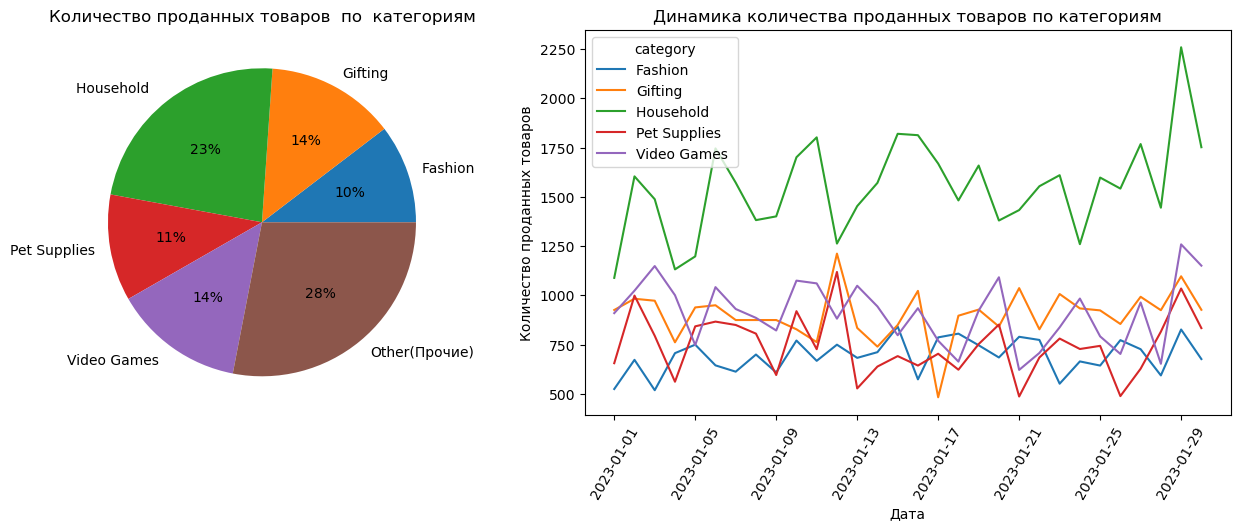

In [55]:
visualize('category', 'sales')

**Вывод:** По общему количеству реализованных товаров лидируют  товары для дома(23%), видеоигры и сувениры(по 14%).

Изучим количество реализованных товаров по категориям.

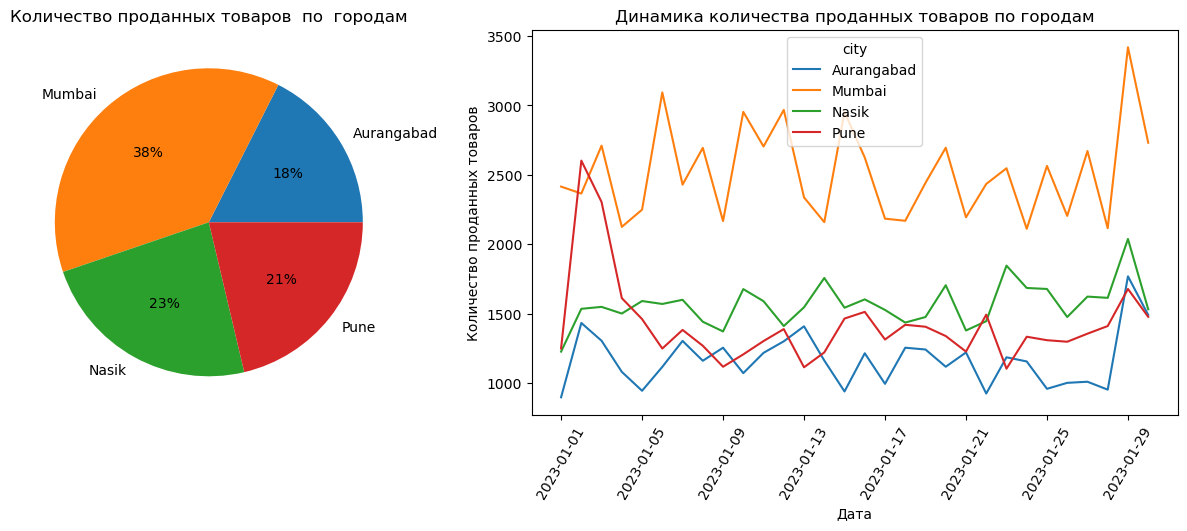

In [56]:
visualize('city', 'sales')

**Вывод** Практически 40% товаров продано в Мумбае. Доля каждого из остальных городов составляет около 20%.

### Изучение общей стоимости реализованных товаров(выручки)

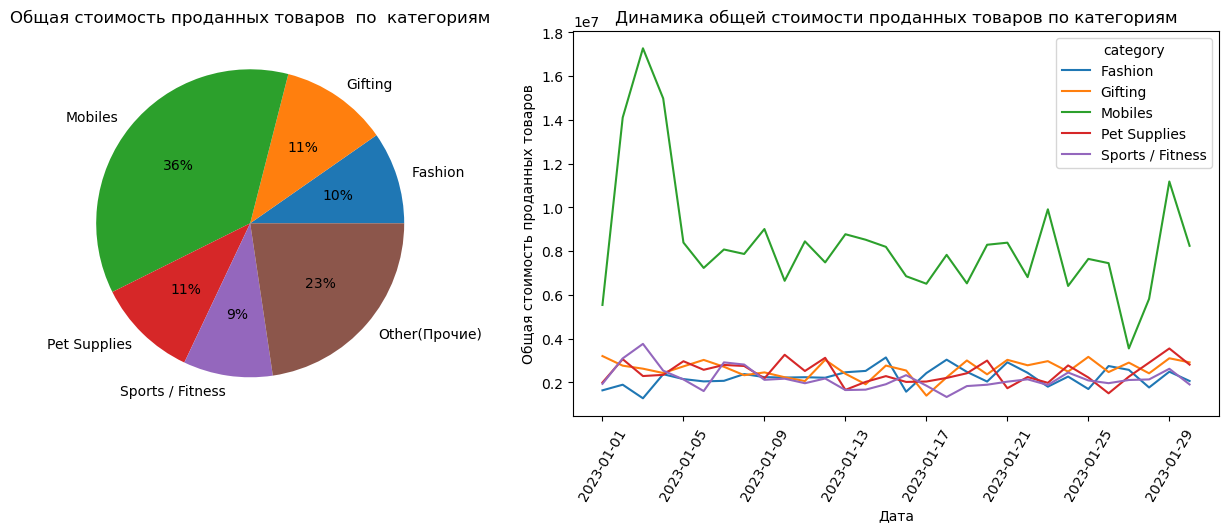

In [57]:
visualize('category', 'total_amount')

**Вывод** По общей стоимости проданной продукции явным лидером являются мобильные телефоны(36%). Доля остальных категорий не превышает 11%.

При этом с течением времени выручка по категориям меняется незначительно. Отмечается лишь рост продаж мобильных телефонов в период с 1 по 5 января.Что может быть связано с новогодними праздниками.

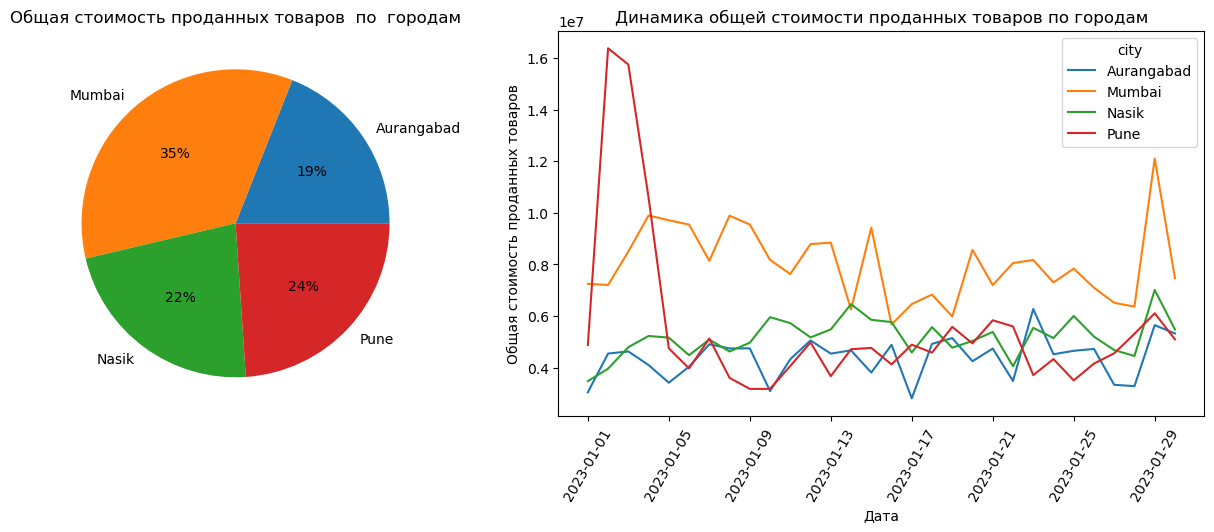

In [58]:
visualize('city', 'total_amount')

**Вывод:** 35% общей выручки принесли магазины, расположенные в Мумбае. Доля остальных городов находится в интервале от 19 до 24%.

Общая структура похожа на структуру продаж по количеству проданных единиц товаров. Однако бросается в глаза резкий рост продаж в городе Пуна с 1 по 5 января.